# RNN text sentiment analyzer

In [1]:
import pandas as pd
from pathlib import Path
import torch
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import torch.nn as nn
import tqdm
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import json
import nltk
from nltk.corpus import stopwords

from utils.text_datasets import (
    get_poem_sentiment_dataset,
    get_basic_tweet_sentiment_dataset,
    get_advanced_tweet_sentiment_dataset,
)
from utils.metrics import display_clasification_metrics, get_metrics

In [2]:
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data

In [29]:
EMBEDDING_SIZE = 100

corpus = api.load("text8")
gensim_model = Word2Vec(corpus, vector_size=EMBEDDING_SIZE)
tokenizer = gensim_model.wv.key_to_index
emb_weights = torch.FloatTensor(gensim_model.wv.vectors)
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


def tokenize_function(examples):
    review_tokenized = []
    all_parsed = 0
    unknows = 0
    for word in examples.split():
        all_parsed += 1
        try:
            review_tokenized.append(tokenizer[word.lower()])
        except:
            unknows += 1
    return review_tokenized

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mikic202/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def pad_collate(batch):
    xx, yy = zip(*batch)
    x_lens = [len(x) - 1 for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy = torch.stack(yy)
    return xx_pad, yy, x_lens

## Poem Dataset

In [31]:
DATASET_NAME = "poem_sentiment"
BATCH_SIZE = 128
NUMBER_OF_CLASSES = 4

train_dataset, validation_dataset, test_dataset = get_poem_sentiment_dataset(
    tokenize_function
)

In [32]:
validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

## Simple Twiter Dataset

In [14]:
DATASET_NAME = "basic_tweet_sentiment"
BATCH_SIZE = 1024
NUMBER_OF_CLASSES = 5

train_dataset, test_dataset = get_basic_tweet_sentiment_dataset(tokenize_function)

train_size = 0.9
train_dataset, validation_dataset = train_test_split(
    train_dataset, train_size=train_size, shuffle=True
)

/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/datasets/load.py:1491: FutureWarning: The repository for stanfordnlp/sentiment140 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/stanfordnlp/sentiment140
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [15]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate
)

## Advanced Twitter Dataset

In [52]:
DATASET_NAME = "advanced_tweet_sentiment"
BATCH_SIZE = 256
NUMBER_OF_CLASSES = 3
CONDITIONAL_SIZE = 13

train_dataset, test_dataset, means, stds = get_advanced_tweet_sentiment_dataset(
    tokenize_function
)

print(train_dataset)

train_size = 0.9
train_dataset, validation_dataset = train_test_split(
    train_dataset, train_size=train_size, shuffle=True
)

/home/mikic202/semestr_8/NLP/NLP-2025/utils/text_datasets.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.text_id] = torch.tensor(self.tokenizer(data[self.text_id]))


In [53]:
def twitter_set_pad_collate(batch):
    xx, yy = zip(*batch)

    x_lens = [len(x["text"]) - 1 for x in xx]
    xx_text = [x["text"] for x in xx]
    conditional = [
        torch.from_numpy(x.drop("text").values.astype(np.float32)) for x in xx
    ]

    xx_pad = pad_sequence(xx_text, batch_first=True, padding_value=0)
    yy = torch.stack(yy)
    return xx_pad, torch.stack(conditional), yy, x_lens

In [54]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=twitter_set_pad_collate
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=twitter_set_pad_collate,
)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=32, shuffle=False, collate_fn=twitter_set_pad_collate
)

# Model

In [8]:
class LstmSentimentClasifier(nn.Module):
    def __init__(
        self,
        embedding_dim,
        hidden_size,
        num_of_rnn_layers,
        out_size,
        emb_weights,
        bidirectional=False,
    ):
        super().__init__()
        self.num_of_rnn_layers = num_of_rnn_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_of_rnn_layers,
            bidirectional=bidirectional,
            batch_first=False,
        )
        self.fc = nn.Linear(hidden_size * self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        state = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden, state

    def forward(self, x, len_x, hidden):
        x = self.embeddings(x)
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        last_seq_items = all_outputs[range(all_outputs.shape[0]), len_x]
        out = last_seq_items
        x = self.fc(out)
        return x, hidden


class ConditionalLstmSentimentClasifier(nn.Module):
    def __init__(
        self,
        embedding_dim,
        hidden_size,
        num_of_rnn_layers,
        out_size,
        emb_weights,
        conditional_embedding_dim,
        bidirectional=False,
    ):
        super().__init__()
        self.num_of_rnn_layers = num_of_rnn_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_of_rnn_layers,
            bidirectional=bidirectional,
            batch_first=False,
        )
        self.fc = nn.Linear(
            hidden_size * self.bidirectional + conditional_embedding_dim, 512
        )
        self.ac1 = nn.LeakyReLU(0.05)
        self.dr1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(512, 128)
        self.dr2 = nn.Dropout(0.1)
        self.ac2 = nn.Hardsigmoid()
        self.fc3 = nn.Linear(128, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        state = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden, state

    def forward(self, x, len_x, hidden, conditions):
        x = self.embeddings(x)
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        last_seq_items = all_outputs[range(all_outputs.shape[0]), len_x]
        out = torch.cat((last_seq_items, conditions), dim=1)
        x = self.fc(out)
        x = self.ac1(x)
        x = self.dr1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.dr2(x)
        x = self.fc3(x)
        return x, hidden

In [9]:
class GruSentimentClasifier(nn.Module):
    def __init__(
        self,
        embedding_dim,
        hidden_size,
        num_of_rnn_layers,
        out_size,
        emb_weights,
        bidirectional=False,
    ):
        super().__init__()
        self.num_of_rnn_layers = num_of_rnn_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_of_rnn_layers,
            bidirectional=bidirectional,
            batch_first=False,
        )
        self.fc = nn.Linear(
            hidden_size * self.bidirectional, (hidden_size * self.bidirectional)
        )
        self.d1 = nn.Dropout(0.1)
        self.ac1 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear((hidden_size * self.bidirectional), out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden

    def forward(self, x, len_x, hidden):
        x = self.embeddings(x)
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.gru(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        last_seq_items = all_outputs[range(all_outputs.shape[0]), len_x]
        out = last_seq_items
        x = self.fc(out)
        x = self.ac1(x)
        x = self.d1(x)
        x = self.fc2(x)
        return x, hidden


class ConditionalGruSentimentClasifier(nn.Module):
    def __init__(
        self,
        embedding_dim,
        hidden_size,
        num_of_rnn_layers,
        out_size,
        emb_weights,
        conditional_embedding_dim,
        bidirectional=False,
    ):
        super().__init__()
        self.num_of_rnn_layers = num_of_rnn_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.embeddings.requires_grad = False
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_of_rnn_layers,
            bidirectional=bidirectional,
            batch_first=False,
        )
        self.fc = nn.Linear(
            hidden_size * self.bidirectional + conditional_embedding_dim, 1024
        )
        self.ac1 = nn.LeakyReLU(0.05)
        self.dr1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(1024, 256)
        self.ac2 = nn.LeakyReLU(0.1)
        self.dr2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(256, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_of_rnn_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden

    def forward(self, x, len_x, hidden, conditions):
        x = self.embeddings(x)
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.gru(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        last_seq_items = all_outputs[range(all_outputs.shape[0]), len_x]
        out = torch.cat((last_seq_items, conditions), dim=1)
        x = self.fc(out)
        x = self.ac1(x)
        self.dr1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.dr2(x)
        x = self.fc3(x)
        return x, hidden

# Utils

In [59]:
def measure_lstm_model(model, data_loader):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_pred = torch.tensor([]).to(device)
    with torch.no_grad():
        for x, targets, len_x in data_loader:
            x = x.to(device).long()
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = model(x, len_x, (hidden, state))
            preds = preds.squeeze(1)
            y_true = torch.cat((y_true, targets), 0)
            y_pred = torch.cat((y_pred, preds.argmax(1)), 0)
    return y_true, y_pred


def measure_gru_model(model, data_loader):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_pred = torch.tensor([]).to(device)
    with torch.no_grad():
        for x, targets, len_x in data_loader:
            x = x.to(device).long()
            targets = targets.to(device)
            hidden = model.init_hidden(x.size(0))
            hidden = hidden.to(device)
            preds, _ = model(x, len_x, hidden)
            preds = preds.squeeze(1)
            y_true = torch.cat((y_true, targets), 0)
            y_pred = torch.cat((y_pred, preds.argmax(1)), 0)
    return y_true, y_pred


def measure_conditional_gru_model(model, data_loader):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_pred = torch.tensor([]).to(device)
    with torch.no_grad():
        for x, cond, targets, len_x in data_loader:
            x = x.to(device).long()
            cond = cond.to(device)
            targets = targets.to(device)
            hidden = model.init_hidden(x.size(0))
            hidden = hidden.to(device)
            preds, _ = model(x, len_x, hidden, cond)
            preds = preds.squeeze(1)
            y_true = torch.cat((y_true, targets), 0)
            y_pred = torch.cat((y_pred, preds.argmax(1)), 0)
    return y_true, y_pred

def measure_conditional_lstm_model(model, data_loader):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_pred = torch.tensor([]).to(device)
    with torch.no_grad():
        for x, cond, targets, len_x in data_loader:
            x = x.to(device).long()
            cond = cond.to(device)
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = model(x, len_x, (hidden, state), cond)
            preds = preds.squeeze(1)
            y_true = torch.cat((y_true, targets), 0)
            y_pred = torch.cat((y_pred, preds.argmax(1)), 0)
    return y_true, y_pred


def measure_model(model, data_loader):
    if "Conditional" in type(model).__name__:
        if hasattr(model, "lstm"):
            return measure_conditional_lstm_model(model, data_loader)
        elif hasattr(model, "gru"):
            return measure_conditional_gru_model(model, data_loader)
    elif hasattr(model, "lstm"):
        return measure_lstm_model(model, data_loader)
    elif hasattr(model, "gru"):
        return measure_gru_model(model, data_loader)


def get_all_measurements(model, train_loader, validation_loader, test_loader):
    df = pd.DataFrame()

    print("Train set metrics")
    plt.figure()

    total_targets, total_preds = measure_model(model, train_loader)
    df["train_targets"] = total_targets.cpu().numpy()
    df["train_preds"] = total_preds.cpu().numpy()
    confusion_matrix_labels = np.unique(total_targets.cpu())
    display_clasification_metrics(
        total_preds.cpu(), total_targets.cpu(), confusion_matrix_labels
    )
    plt.figure()

    print("\nValidation set metrics")
    total_targets, total_preds = measure_model(model, validation_loader)
    df["validation_targets"] = pd.Series(total_targets.cpu().numpy())
    df["validation_preds"] = pd.Series(total_preds.cpu().numpy())
    display_clasification_metrics(
        total_preds.cpu(), total_targets.cpu(), confusion_matrix_labels
    )

    plt.figure()

    print("\nTest set metrics")
    total_targets, total_preds = measure_model(model, test_loader)
    df["test_targets"] = pd.Series(total_targets.cpu().numpy())
    df["test_preds"] = pd.Series(total_preds.cpu().numpy())
    display_clasification_metrics(
        total_preds.cpu(), total_targets.cpu(), confusion_matrix_labels
    )
    return df

In [12]:
def test_multiple_params(
    model_classes: list, model_params: list, loss_fn: list, epochs_nums: list, lrs: list
):
    model_id = 0
    for model_class, modle_param, loss, lr, epochs in zip(
        model_classes, model_params, loss_fn, lrs, epochs_nums
    ):
        model = model_class(*modle_param).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = loss.to(device)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

        print(f"Training {model_class.__name__} with params {modle_param} and lr {lr}")
        model, train_loss_trajectory, validation_loss_trajectory = train_model(
            model,
            optimizer,
            loss_fn,
            train_loader,
            validation_loader,
            epochs,
            scheduler,
        )
        path = Path(f"models/multiple_tests/{DATASET_NAME}/{model_id}")
        path.mkdir(parents=True, exist_ok=True)
        plt.plot(train_loss_trajectory, label="Train loss")
        plt.plot(validation_loss_trajectory, label="Validation loss")
        plt.legend()
        plt.savefig(path / "loss.png")
        plt.clf()
        model_id += 1
        test_metrics = measure_model(model, test_loader)
        test_metrics = get_metrics(test_metrics[1].cpu(), test_metrics[0].cpu())
        test_metrics["confusion_matrix"] = test_metrics["confusion_matrix"].tolist()
        train_metrics = measure_model(model, train_loader)
        train_metrics = get_metrics(train_metrics[1].cpu(), train_metrics[0].cpu())
        train_metrics["confusion_matrix"] = train_metrics["confusion_matrix"].tolist()
        validation_metrics = measure_model(model, validation_loader)
        validation_metrics = get_metrics(
            validation_metrics[1].cpu(), validation_metrics[0].cpu()
        )
        validation_metrics["confusion_matrix"] = validation_metrics[
            "confusion_matrix"
        ].tolist()

        with open(path / "metrics.json", "w") as f:
            json.dump(
                {
                    "train": train_metrics,
                    "validation": validation_metrics,
                    "test": test_metrics,
                },
                f,
                indent=4,
            )
        torch.save(model.cpu().state_dict(), path / "model.pt")


def train_lstm(
    model, optimizer, loss_fn, train_loader, validation_loader, epochs, scheduler
):
    progress_bar = tqdm.tqdm(range(epochs), total=epochs, desc="Epoch")
    train_loss_trajectory = []
    validation_loss_trajectory = []
    for _ in progress_bar:
        losses = 0
        batches = 0
        for x, targets, len_x in train_loader:
            x = x.to(device).long()
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = model(x, len_x, (hidden, state))
            preds = preds.squeeze(1)
            optimizer.zero_grad()
            loss = loss_fn(preds, targets)
            loss.backward()
            optimizer.step()
            losses += loss.item()
            batches += 1
        with torch.no_grad():
            validation_loss = 0
            validation_batches = 0
            for x, targets, len_x in validation_loader:
                validation_batches += 1
                x = x.to(device).long()
                targets = targets.to(device)
                hidden, state = model.init_hidden(x.size(0))
                hidden, state = hidden.to(device), state.to(device)
                preds, _ = model(x, len_x, (hidden, state))
                preds = preds.squeeze(1)
                loss = loss_fn(preds, targets)
                validation_loss += loss.item()
        scheduler.step()
        train_loss_trajectory.append(losses / batches)
        validation_loss_trajectory.append(validation_loss / validation_batches)
        progress_bar.set_postfix(
            {
                "Train loss": losses / batches,
                "Validation loss": validation_loss / validation_batches,
            }
        )
    return model, train_loss_trajectory, validation_loss_trajectory


def train_gru(
    model, optimizer, loss_fn, train_loader, validation_loader, epochs, scheduler
):
    progress_bar = tqdm.tqdm(range(epochs), total=epochs, desc="Epoch")
    train_loss_trajectory = []
    validation_loss_trajectory = []
    for _ in progress_bar:
        losses = 0
        batches = 0
        for x, targets, len_x in train_loader:
            x = x.to(device).long()
            targets = targets.to(device)
            hidden = model.init_hidden(x.size(0))
            hidden = hidden.to(device)
            preds, _ = model(x, len_x, hidden)
            preds = preds.squeeze(1)
            optimizer.zero_grad()
            loss = loss_fn(preds, targets)
            loss.backward()
            optimizer.step()
            losses += loss.item()
            batches += 1
        with torch.no_grad():
            validation_loss = 0
            validation_batches = 0
            for x, targets, len_x in validation_loader:
                validation_batches += 1
                x = x.to(device).long()
                targets = targets.to(device)
                hidden = model.init_hidden(x.size(0))
                hidden = hidden.to(device)
                preds, _ = model(x, len_x, hidden)
                preds = preds.squeeze(1)
                loss = loss_fn(preds, targets)
                validation_loss += loss.item()
        scheduler.step()
        train_loss_trajectory.append(losses / batches)
        validation_loss_trajectory.append(validation_loss / validation_batches)
        progress_bar.set_postfix(
            {
                "Train loss": losses / batches,
                "Validation loss": validation_loss / validation_batches,
            }
        )
    return model, train_loss_trajectory, validation_loss_trajectory


def train_model(
    model, optimizer, loss_fn, train_loader, validation_loader, epochs, scheduler
):
    if hasattr(model, "lstm"):
        return train_lstm(
            model,
            optimizer,
            loss_fn,
            train_loader,
            validation_loader,
            epochs,
            scheduler,
        )
    elif hasattr(model, "gru"):
        return train_gru(
            model,
            optimizer,
            loss_fn,
            train_loader,
            validation_loader,
            epochs,
            scheduler,
        )

# Training

## LSTM

In [33]:
number_of_lstm_layers = 4
number_of_lstm_neurons_in_layer = 64
is_biderectional = False

learning_rate = 0.0005
EPOCHS = 15
scheduler_step_size = 1
scheduler_gamma = 0.5

use_weights = True
weights = [1.1, 1.1, 0.47, 1.5]

In [34]:
model = LstmSentimentClasifier(
    EMBEDDING_SIZE,
    number_of_lstm_neurons_in_layer,
    number_of_lstm_layers,
    NUMBER_OF_CLASSES,
    emb_weights,
    bidirectional=is_biderectional,
).to(device)
print(model)

train_loss_trajectory = []
validation_loss_trajectory = []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if use_weights:
    loss_fun = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
else:
    loss_fun = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
)

progress_bar = tqdm.tqdm(range(EPOCHS), total=EPOCHS, desc="Epoch")

model.train()

for epoch in progress_bar:
    losses = 0
    batches = 0
    for x, targets, len_x in train_loader:
        x = x.to(device).long()
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, len_x, (hidden, state))
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        batches += 1
    with torch.no_grad():
        validation_loss = 0
        validation_batches = 0
        for x, targets, len_x in validation_loader:
            validation_batches += 1
            x = x.to(device).long()
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = model(x, len_x, (hidden, state))
            preds = preds.squeeze(1)
            loss = loss_fun(preds, targets)
            validation_loss += loss.item()
    train_loss_trajectory.append(losses / batches)
    validation_loss_trajectory.append(validation_loss / validation_batches)
    progress_bar.set_postfix(
        {
            "Train loss": losses / batches,
            "Validation loss": validation_loss / validation_batches,
        }
    )

LstmSentimentClasifier(
  (embeddings): Embedding(71290, 100)
  (lstm): LSTM(100, 64, num_layers=4)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 100%|██████████| 15/15 [00:01<00:00, 12.96it/s, Train loss=1.06, Validation loss=1.27]


Train set metrics
F1 Score 0.47008801502972597
Accuracy 0.6446188340807175
Recall 0.4827590054973029

Validation set metrics
F1 Score 0.2664285714285714
Accuracy 0.5333333333333333
Recall 0.27118948265805176

Test set metrics


/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1 Score 0.2439814814814815
Accuracy 0.5288461538461539
Recall 0.25648360030511064


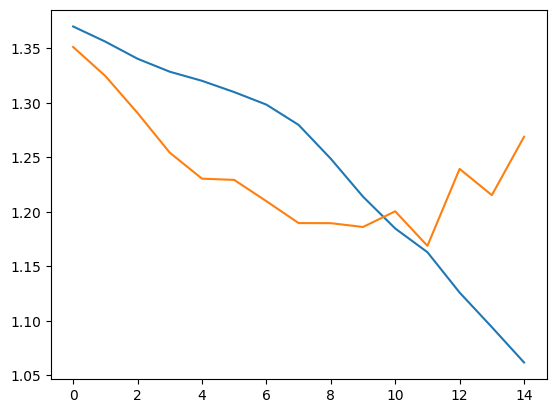

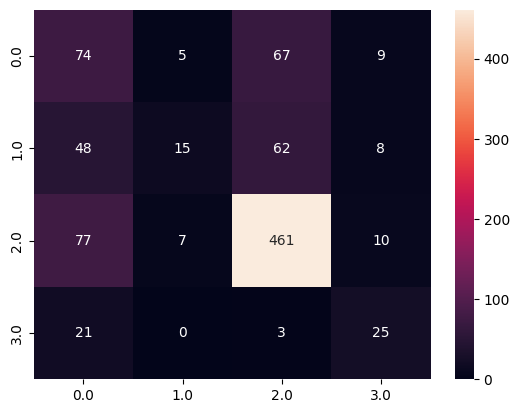

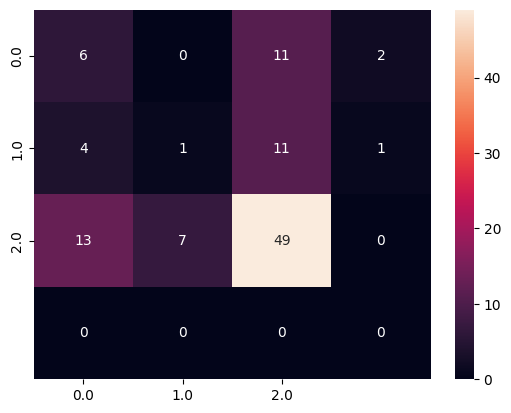

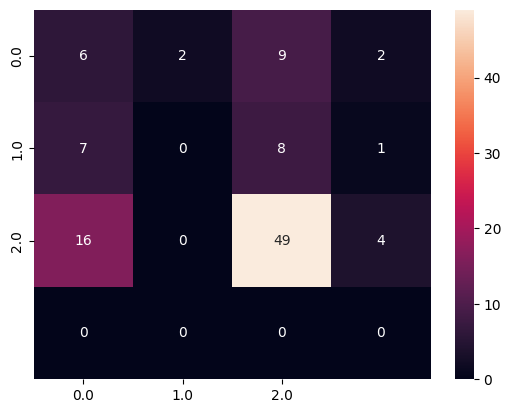

In [35]:
plt.plot(train_loss_trajectory, label="Train loss")
plt.plot(validation_loss_trajectory, label="Validation loss")

_ = get_all_measurements(model, train_loader, validation_loader, test_loader)

## GRU

In [39]:
number_of_gru_layers = 4
number_of_gru_neurons_in_layer = 64
is_biderectional = True

learning_rate = 0.0009
EPOCHS = 10
scheduler_step_size = 1
scheduler_gamma = 0.9

use_weights = True
weights = [1.05, 1.2, 0.5, 1.5]

In [40]:
model = GruSentimentClasifier(
    EMBEDDING_SIZE,
    number_of_gru_neurons_in_layer,
    number_of_gru_layers,
    NUMBER_OF_CLASSES,
    emb_weights,
    bidirectional=is_biderectional,
).to(device)
print(model)


train_loss_trajectory = []
validation_loss_trajectory = []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if use_weights:
    loss_fun = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
else:
    loss_fun = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
)

progress_bar = tqdm.tqdm(range(EPOCHS), total=EPOCHS, desc="Epoch")

model.train()

for epoch in progress_bar:
    losses = 0
    batches = 0
    for x, targets, len_x in train_loader:
        x = x.to(device).long()
        targets = targets.to(device)
        hidden = model.init_hidden(x.size(0))
        hidden = hidden.to(device)
        preds, _ = model(x, len_x, hidden)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        batches += 1
    with torch.no_grad():
        validation_loss = 0
        validation_batches = 0
        for x, targets, len_x in validation_loader:
            validation_batches += 1
            x = x.to(device).long()
            targets = targets.to(device)
            hidden = model.init_hidden(x.size(0))
            hidden = hidden.to(device)
            preds, _ = model(x, len_x, hidden)
            preds = preds.squeeze(1)
            loss = loss_fun(preds, targets)
            validation_loss += loss.item()
    scheduler.step()
    train_loss_trajectory.append(losses / batches)
    validation_loss_trajectory.append(validation_loss / validation_batches)
    progress_bar.set_postfix(
        {
            "Train loss": losses / batches,
            "Validation loss": validation_loss / validation_batches,
        }
    )

GruSentimentClasifier(
  (embeddings): Embedding(71290, 100)
  (gru): GRU(100, 64, num_layers=4, bidirectional=True)
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (d1): Dropout(p=0.1, inplace=False)
  (ac1): LeakyReLU(negative_slope=0.1)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [00:01<00:00,  7.53it/s, Train loss=0.96, Validation loss=1.16]


Train set metrics
F1 Score 0.5888069760564998
Accuracy 0.7253363228699552
Recall 0.5593040547563952

Validation set metrics
F1 Score 0.3072043371339146
Accuracy 0.580952380952381
Recall 0.2908534123031363

Test set metrics
F1 Score 0.33278453225261734
Accuracy 0.5865384615384616
Recall 0.30962766971777267


/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


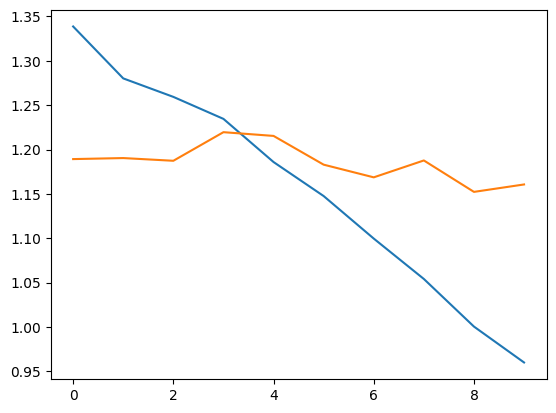

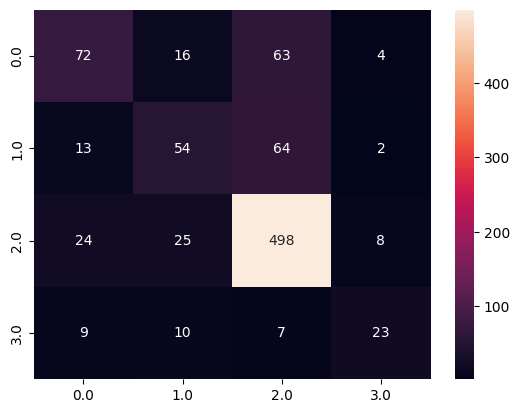

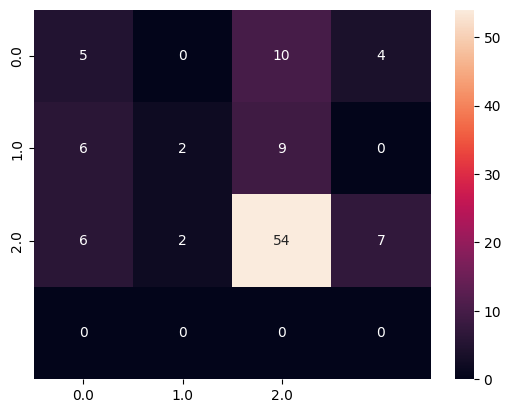

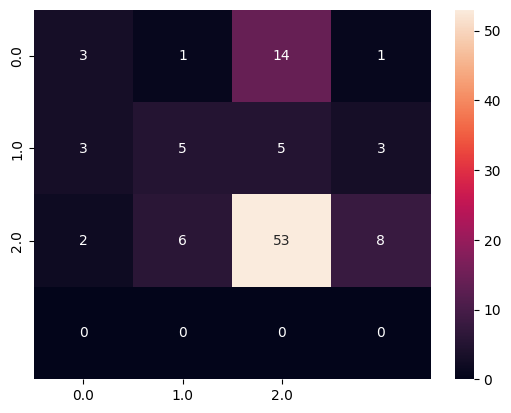

In [41]:
plt.plot(train_loss_trajectory, label="Train loss")
plt.plot(validation_loss_trajectory, label="Validation loss")

_ = get_all_measurements(model, train_loader, validation_loader, test_loader)

## Conditional LSTM

In [55]:
number_of_lstm_layers = 2
number_of_lstm_neurons_in_layer = 128
is_biderectional = True

learning_rate = 0.0005
EPOCHS = 5
scheduler_step_size = 1
scheduler_gamma = 0.5

use_weights = True
weights = [0.91, 0.833, 1.0]

In [56]:
model = ConditionalLstmSentimentClasifier(
    EMBEDDING_SIZE,
    number_of_lstm_neurons_in_layer,
    number_of_lstm_layers,
    NUMBER_OF_CLASSES,
    emb_weights,
    conditional_embedding_dim=CONDITIONAL_SIZE,
    bidirectional=is_biderectional,
).to(device)

train_loss_trajectory = []
validation_loss_trajectory = []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if use_weights:
    loss_fun = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
else:
    loss_fun = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
)

progress_bar = tqdm.tqdm(range(EPOCHS), total=EPOCHS, desc="Epoch")

model.train()

for epoch in progress_bar:
    losses = 0
    batches = 0
    for x, cond, targets, len_x in train_loader:
        x = x.to(device).long()
        targets = targets.to(device)
        cond = cond.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, len_x, (hidden, state), cond)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        batches += 1
    with torch.no_grad():
        validation_loss = 0
        validation_batches = 0
        for x, cond, targets, len_x in validation_loader:
            validation_batches += 1
            cond = cond.to(device)
            x = x.to(device).long()
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = model(x, len_x, (hidden, state), cond)
            preds = preds.squeeze(1)
            loss = loss_fun(preds, targets)
            validation_loss += loss.item()
    scheduler.step()
    train_loss_trajectory.append(losses / batches)
    validation_loss_trajectory.append(validation_loss / validation_batches)
    progress_bar.set_postfix(
        {
            "Train loss": losses / batches,
            "Validation loss": validation_loss / validation_batches,
        }
    )

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 100%|██████████| 5/5 [01:02<00:00, 12.41s/it, Train loss=0.935, Validation loss=0.944]


Train set metrics
F1 Score 0.5524338690425616
Accuracy 0.551997412259421
Recall 0.5537237926944886

Validation set metrics
F1 Score 0.5492123642031984
Accuracy 0.549490538573508
Recall 0.5517247969910368

Test set metrics


/home/mikic202/semestr_8/NLP/NLP-2025/utils/text_datasets.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.text_id] = torch.tensor(self.tokenizer(data[self.text_id]))
/home/mikic202/semestr_8/NLP/NLP-2025/utils/text_datasets.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.text_id] = torch.tensor(self.tokenizer(data[self.text_id]))
/home/mikic202/semestr_8/NLP/NLP-2025/utils/text_datasets.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

F1 Score 0.5418648548552868
Accuracy 0.5421618562535371
Recall 0.5423038732195576


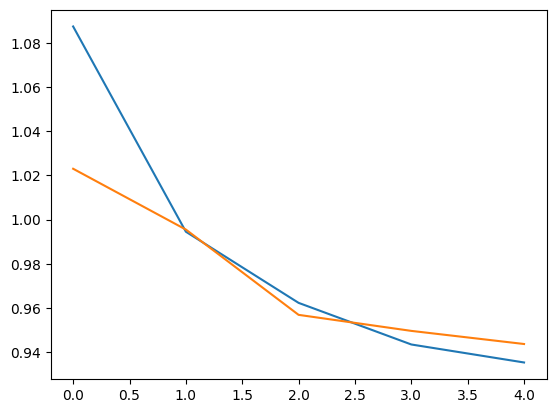

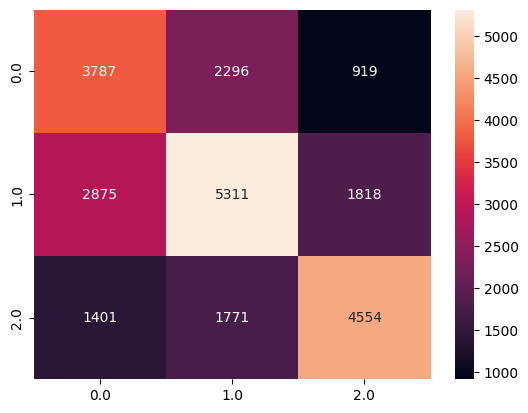

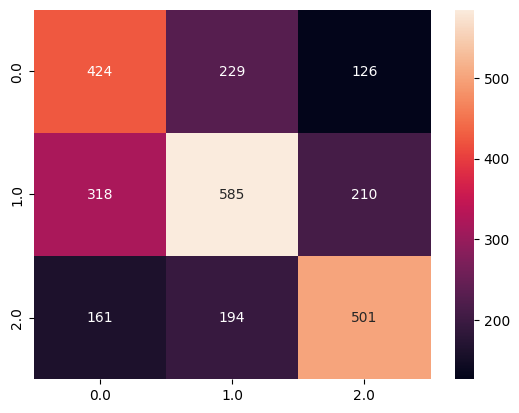

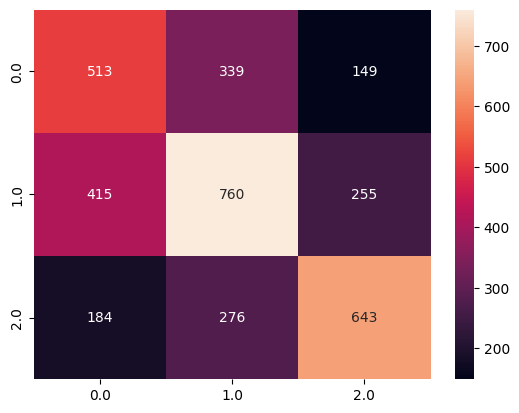

In [61]:
plt.plot(train_loss_trajectory, label="Train loss")
plt.plot(validation_loss_trajectory, label="Validation loss")

_ = get_all_measurements(model, train_loader, validation_loader, test_loader)

## Conditional GRU

In [62]:
number_of_gru_layers = 3
number_of_gru_neurons_in_layer = 256
is_biderectional = True

learning_rate = 0.00085
EPOCHS = 5
scheduler_step_size = 1
scheduler_gamma = 0.9

use_weights = True
weights = [0.918, 0.846, 1.1]

In [63]:
model = ConditionalGruSentimentClasifier(
    EMBEDDING_SIZE,
    number_of_gru_neurons_in_layer,
    number_of_gru_layers,
    NUMBER_OF_CLASSES,
    emb_weights,
    conditional_embedding_dim=CONDITIONAL_SIZE,
    bidirectional=is_biderectional,
).to(device)

print(model)

train_loss_trajectory = []
validation_loss_trajectory = []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if use_weights:
    loss_fun = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
else:
    loss_fun = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
)

progress_bar = tqdm.tqdm(range(EPOCHS), total=EPOCHS, desc="Epoch")

model.train()

for epoch in progress_bar:
    losses = 0
    batches = 0
    for x, cond, targets, len_x in train_loader:
        x = x.to(device).long()
        targets = targets.to(device)
        cond = cond.to(device)
        hidden = model.init_hidden(x.size(0))
        hidden = hidden.to(device)
        preds, _ = model(x, len_x, hidden, cond)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        batches += 1
    with torch.no_grad():
        validation_loss = 0
        validation_batches = 0
        for x, cond, targets, len_x in validation_loader:
            validation_batches += 1
            cond = cond.to(device)
            x = x.to(device).long()
            targets = targets.to(device)
            hidden = model.init_hidden(x.size(0))
            hidden = hidden.to(device)
            preds, _ = model(x, len_x, hidden, cond)
            preds = preds.squeeze(1)
            loss = loss_fun(preds, targets)
            validation_loss += loss.item()
    scheduler.step()
    train_loss_trajectory.append(losses / batches)
    validation_loss_trajectory.append(validation_loss / validation_batches)
    progress_bar.set_postfix(
        {
            "Train loss": losses / batches,
            "Validation loss": validation_loss / validation_batches,
        }
    )

ConditionalGruSentimentClasifier(
  (embeddings): Embedding(71290, 100)
  (gru): GRU(100, 256, num_layers=3, bidirectional=True)
  (fc): Linear(in_features=525, out_features=1024, bias=True)
  (ac1): LeakyReLU(negative_slope=0.05)
  (dr1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (ac2): LeakyReLU(negative_slope=0.1)
  (dr2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)


Epoch: 100%|██████████| 5/5 [02:47<00:00, 33.53s/it, Train loss=0.807, Validation loss=0.84] 


Train set metrics
F1 Score 0.6474637278310187
Accuracy 0.6505741549409672
Recall 0.6481564367968524

Validation set metrics
F1 Score 0.6049754220561763
Accuracy 0.608806404657933
Recall 0.6067214875833777

Test set metrics


/home/mikic202/semestr_8/NLP/NLP-2025/utils/text_datasets.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.text_id] = torch.tensor(self.tokenizer(data[self.text_id]))
/home/mikic202/semestr_8/NLP/NLP-2025/utils/text_datasets.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.text_id] = torch.tensor(self.tokenizer(data[self.text_id]))
/home/mikic202/semestr_8/NLP/NLP-2025/utils/text_datasets.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

F1 Score 0.6159500146872764
Accuracy 0.6179966044142614
Recall 0.6194273541508356


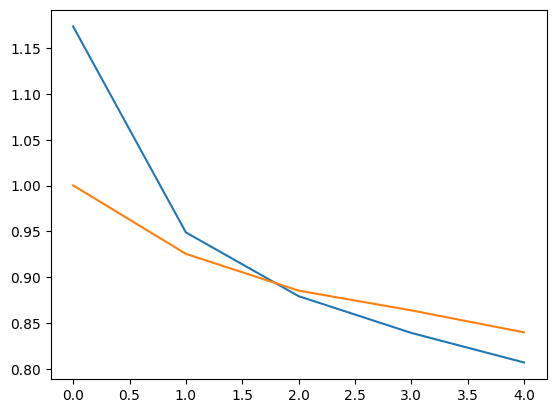

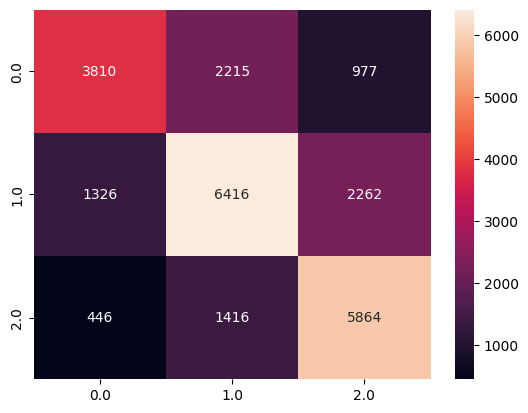

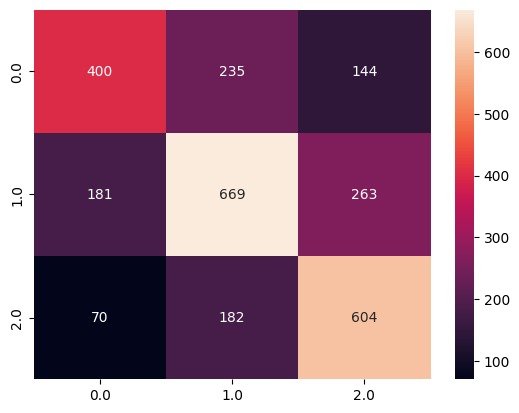

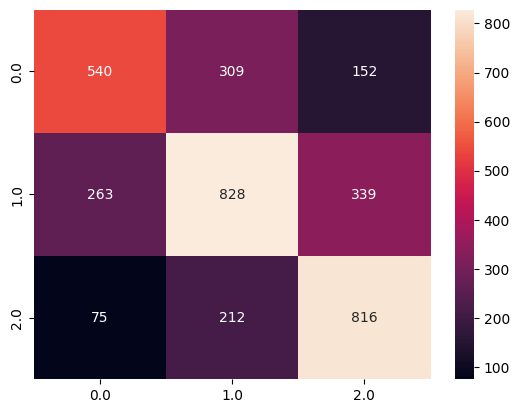

In [64]:
plt.plot(train_loss_trajectory, label="Train loss")
plt.plot(validation_loss_trajectory, label="Validation loss")

_ = get_all_measurements(model, train_loader, validation_loader, test_loader)

## Bulk tests

In [ ]:
models_to_test = [LstmSentimentClasifier] * 3 + [GruSentimentClasifier] * 3
modle_params = [
    [100, 128, 3, 5, emb_weights, True],  # *
    [100, 256, 2, 5, emb_weights, False],  # *
    [100, 128, 2, 5, emb_weights, True],  # *
    # __________________________________
    [100, 64, 2, 5, emb_weights, True],  # *
    [100, 128, 2, 5, emb_weights, False],  # *
    [100, 64, 2, 5, emb_weights, False],
]
loss_fun = [nn.CrossEntropyLoss()] * 12
epochs_nums = [5, 5, 6, 12, 12, 12]
lrs = [0.0008] * 12

test_multiple_params(models_to_test, modle_params, loss_fun, epochs_nums, lrs)

## Save models

Train set metrics
F1 Score 0.7879642991793556
Accuracy 0.7882590277777778
Recall 0.7882442408413008

Validation set metrics


/home/mikic202/miniconda3/envs/pt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1 Score 0.4910534226444871
Accuracy 0.7368875
Recall 0.4913475911981153

Test set metrics
F1 Score 0.4258884054280474
Accuracy 0.5481927710843374
Recall 0.5063119554644978


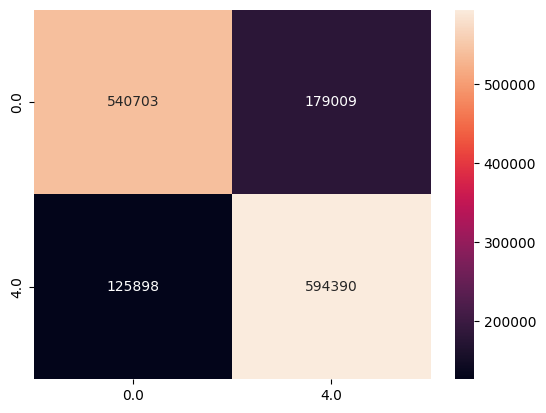

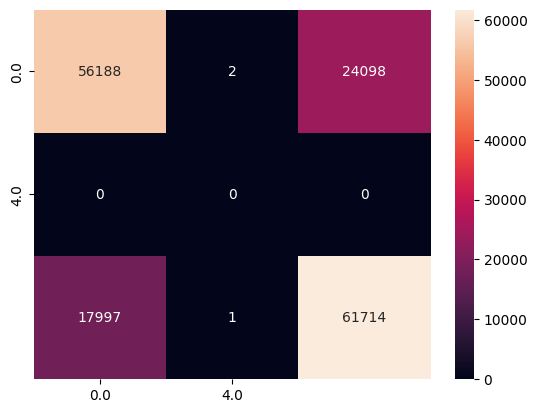

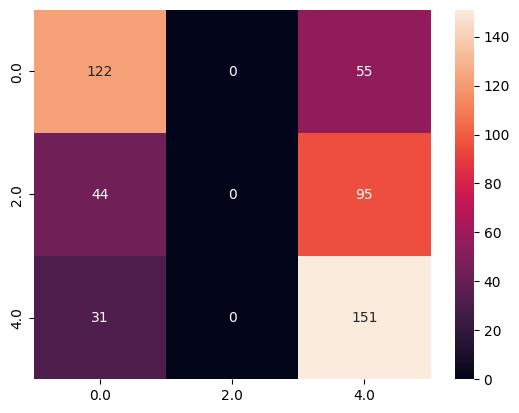

In [22]:
df = get_all_measurements(model, train_loader, validation_loader, test_loader)

In [178]:
df.to_csv(f"results/{DATASET_NAME}_gru_3.csv", index=False)

In [152]:
df.to_csv(f"results/{DATASET_NAME}_lstm_2.csv", index=False)

In [153]:
torch.save(
    model.cpu().state_dict(),
    "models/lstm_sentiment_basic_tweet_acc_82_78_54,100,128,2,5,bidirectional.pth",
)

In [177]:
torch.save(
    model.cpu().state_dict(),
    "models/gru_sentiment_basic_tweet_acc_81_78_55,100,64,4,5,bidirectional_lrelu_0.1.pth",
)